<a href="https://colab.research.google.com/github/gabrielborja/python_data_analysis/blob/main/production_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily Production Analysis

## Uploading packages and data

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Remove previous versions of the uploaded excel file
!rm production_j4_2021.xlsx

rm: cannot remove 'production_j4_2021.xlsx': No such file or directory


In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded = files.upload()

In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded['production_j4_2021.xlsx']), index_col='Event') #==> setting Event (datetime) as index to perform date slicing

In [ ]:
#Checking the dataframe information
df.info()

In [ ]:
#Checking the dataframe index
df.index[0], df.index[-1]

## Filtering data for daily meeting

In [ ]:
#Filtering the dataframe to match the last 24 hours
s = '2021-05-27 08:00:00'
f = '2021-05-28 07:00:00'
last_24 = df[s : f].copy()
last_24.index[0], last_24.index[-1]

(Timestamp('2021-05-05 08:00:00'), Timestamp('2021-05-07 07:00:00'))

In [ ]:
#Grouping and aggregating the data to estimate different parameters for each shift and day

def util(x):
  '''Custom function to calculate the utilization of each machine'''
  return (x.sum()/x.count())*100

groupped = last_24.groupby(['Weeknum', 'S_num', 'Shift', 'Mass', 'Group', 'Product', 'Format']).agg({'Form_min': 'mean',
                                                                                                    'Hours': 'count',
                                                                                                    'Boxes': 'sum',
                                                                                                    'GE': 'mean',
                                                                                                    'GE_loss': 'mean',
                                                                                                    'Min_loss': 'sum',
                                                                                                    'A1764': util,
                                                                                                    'PK2219': util,
                                                                                                    'PK2845': util,
                                                                                                    'PK4553': util,
                                                                                                    'Schubert': util,
                                                                                                    'K6316': util,
                                                                                                    'TP6839': util
                                                                                                    }).reset_index()

In [ ]:
#Exporting to excel into local disk
from google.colab import files
groupped.to_excel('z_grouped_24.xlsx', index=False) #==> Excluding index from file
files.download('z_grouped_24.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Demand Planning

##Loading neccesary libraries

In [ ]:
#Upgrading Ploty
!pip install plotly --upgrade

In [ ]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

##Loading demand dataset

In [ ]:
#Remove previous versions of the uploaded excel file
!rm 2021_j4_demand.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded3_a = files.upload()

In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df3_a = pd.read_excel(io.BytesIO(uploaded3_a['2021_j4_demand.xlsx']))

In [ ]:
#Parse date column and set date as index to perform date slicing
df3_a = df3_a.assign(Art_num = df3_a['Art_num'].astype(int),
                 Process_order = df3_a['Process_order'].astype(int),
                 Number_sku = round(df3_a['Number_sku'], 0))

In [ ]:
#Checking the dataframe information
df3_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Weeknum        297 non-null    int64  
 1   Art_num        297 non-null    int64  
 2   Product        297 non-null    object 
 3   Artikkel       297 non-null    object 
 4   Process_order  297 non-null    int64  
 5   Volume_kg      297 non-null    float64
 6   Number_sku     297 non-null    float64
 7   Pallets        297 non-null    float64
 8   Warehouse      294 non-null    object 
 9   Notes          29 non-null     object 
dtypes: float64(3), int64(3), object(4)
memory usage: 23.3+ KB


##Loading production dataset

In [ ]:
#Remove previous versions of the uploaded excel file
!rm 2021_j4_vrak.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded3_b = files.upload()

In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df3_b = pd.read_excel(io.BytesIO(uploaded3_b['2021_j4_vrak.xlsx']))

In [ ]:
#Extracting day name from datetime
df3_b = df3_b.set_index('Date')
#df3_b = df3_b.assign(Day = df3_b.index.day_name()).reset_index()
df3_b = df3_b.assign(Day = df3_b.index.dayofweek).reset_index()

In [ ]:
#Extracting week number date from datetime
df3_b = df3_b.assign(Weeknum = df3_b['Date'].dt.isocalendar().week)

In [ ]:
#Checking the dataframe information
df3_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            152 non-null    datetime64[ns]
 1   Line            152 non-null    object        
 2   Prod_vol_kg     152 non-null    float64       
 3   Scrap_kg        152 non-null    float64       
 4   Rework_kg       152 non-null    int64         
 5   Gross_waste_kg  152 non-null    float64       
 6   Gross_waste_%   152 non-null    float64       
 7   Day             152 non-null    int64         
 8   Weeknum         152 non-null    UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 10.4+ KB


##EDA articles demand

In [ ]:
#Grouping by number of articles per week
df3_count = df3_a.groupby(by=['Weeknum']).agg(Article_count = ('Art_num', 'count')).reset_index()
df3_count[-2:]

,Weeknum,Article_count
33,34,12
34,35,6


In [ ]:
#Grouping by total planned demand per week
df3_demand = df3_a.groupby(by=['Weeknum']).agg(Demand_kg = ('Volume_kg', 'sum')).reset_index()
df3_demand[-2:]

,Weeknum,Demand_kg
33,34,66000.0
34,35,68000.0


In [ ]:
#Grouping by article demand for the whole period
df3_product = df3_a.groupby(by=['Art_num', 'Product']).agg(Product_kg = ('Volume_kg', 'sum'))
df3_product = df3_product.sort_values(by=['Product_kg'], ascending=False).reset_index()
df3_product[-1:]

,Art_num,Product,Product_kg
24,9999999,Holiday,0.0


In [ ]:
#Exporting to excel into local disk
from google.colab import files
df3_product.to_excel('2021_j4_product_demand.xlsx', index=False) #==>  Exclude index on created file.
files.download('2021_j4_product_demand.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##EDA process capability

In [ ]:
#Grouping by produced volume per week, excluding saturdays and sundays
df3_wk_prod = df3_b[~df3_b['Day'].isin([5, 6])].groupby(by=['Weeknum']).agg(Real_vol_kg = ('Prod_vol_kg', 'sum')).reset_index()

#Assigning old plan vs new plan category
df3_wk_prod = df3_wk_prod.assign(Plan = np.where(df3_wk_prod['Weeknum']<14,'Old_plan', 'RFS_plan'))
df3_wk_prod[-2:]

,Weeknum,Real_vol_kg,Plan
28,32,38293.052,RFS_plan
29,33,53534.460,RFS_plan


In [ ]:
#Grouping by produced volume per week, excluding saturdays and sundays
df3_weekends = df3_b[df3_b['Day'].isin([5, 6])].groupby(by=['Weeknum']).agg(Weekend_vol_kg = ('Prod_vol_kg', 'sum')).reset_index()
df3_weekends[-2:]

,Weeknum,Weekend_vol_kg
8,31,4952.640
9,33,8093.064


In [ ]:
#Grouping by produced volume per week, excluding saturdays and sundays
df3_days = df3_b.assign(Plan = np.where(df3_b['Weeknum']<14,'Old_plan', 'RFS_plan'))
df3_days = df3_days.groupby(by=['Plan', 'Day']).agg(Kg_per_day = ('Prod_vol_kg', 'mean')).reset_index()

In [ ]:
#Replacing integer days to name of day
days_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df3_days['Day'] = df3_days['Day'].replace(to_replace=days_dict)
df3_days[-2:]

,Plan,Day,Kg_per_day
12,RFS_plan,Saturday,4241.218333
13,RFS_plan,Sunday,5042.076667


##Merging all dataframes by weeknum

In [ ]:
#Merging dataframes on the weeknum
df3 = df3_count.merge(df3_demand, how='left', on='Weeknum')
df3 = df3.merge(df3_wk_prod, how='left', on='Weeknum')
df3 = df3.merge(df3_weekends, how='left', on='Weeknum')
df3.tail()

,Weeknum,Article_count,Demand_kg,Real_vol_kg,Plan,Weekend_vol_kg
30,31,6,44500.0,36556.240,RFS_plan,4952.640
31,32,10,57000.0,38293.052,RFS_plan,NaN
32,33,12,64000.0,53534.460,RFS_plan,8093.064
33,34,12,66000.0,NaN,NaN,NaN
34,35,6,68000.0,NaN,NaN,NaN


In [ ]:
#Exporting to excel into local disk
from google.colab import files
df3.to_excel('2021_j4_real_prod.xlsx', index=False) #==>  Exclude index on created file.
files.download('2021_j4_real_prod.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Demand Visualization

In [ ]:
#Plotting the demand vs real production for the year
fig3_a = px.bar(data_frame=df3, x='Weeknum', y=['Demand_kg', 'Real_vol_kg', 'Weekend_vol_kg'], title='J4 Demand vs Real Production',
                barmode='group', width=900, height=450)
fig3_a.show()

In [ ]:
#Plotting the real production comparing both production plans
df3_box = df3[df3['Real_vol_kg']>40000]
fig3_b= px.bar(data_frame=df3_box, x='Weeknum', y='Real_vol_kg', title='J4 Old plan vs RFS',
                color='Plan', width=900, height=450)
fig3_b.show()

In [ ]:
#Plotting the demand vs real production for the year
fig3_c = px.box(data_frame=df3_box, x='Real_vol_kg', color='Plan',
                      title='J4 Box Plot - Old plan vs RFS', width=900, height=450)
fig3_c.show()

In [ ]:
#Plotting the demand vs real production for the year
fig3_c = px.bar(data_frame=df3_days, x='Day', y='Kg_per_day', color='Plan', barmode='group',
                      title='J4 Average Daily Volume - Old plan vs RFS', width=900, height=450)
fig3_c.show()

#Create time series template

In [ ]:
#Creating a dataframe with time series for each hour, and computing categorical values for year, week number and weekday
ts = pd.DataFrame()
ts = ts.assign(Event = pd.date_range(start='2021-07-01', end='2022-12-31', freq='D', name='Event'))
ts = ts.assign(#Year = ts['Event'].dt.isocalendar().year,
#               Month = ts['Event'].dt.month_name(),
#               Weeknum = ts['Event'].dt.isocalendar().week,
               Weekday = ts['Event'].dt.day_name())

In [ ]:
#Checking the time series dataframe
ts.tail()

,Event,Weekday
544,2022-12-27,Tuesday
545,2022-12-28,Wednesday
546,2022-12-29,Thursday
547,2022-12-30,Friday
548,2022-12-31,Saturday


In [ ]:
#Checking the dataframe info
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Event    549 non-null    datetime64[ns]
 1   Weekday  549 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.7+ KB


In [ ]:
from google.colab import files
ts.to_excel('time_series_template.xlsx', index=False) #==> Excluding index from file
files.download('time_series_template.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Weekly Production Analysis

##Uploading packages and data

In [ ]:
#Upgrading Plotly
!pip install plotly --upgrade

In [1]:
#Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact

In [2]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Removing previous versions of the uploaded excel file
!rm 2021_effektivitet_j4.xlsx

In [3]:
#Uploading file from local drive
from google.colab import files
uploaded7 = files.upload()

Saving 2021_effektivitet_j4.xlsx to 2021_effektivitet_j4.xlsx


In [4]:
#Storing dataset in a Pandas Dataframe
import io
df7 = pd.read_excel(io.BytesIO(uploaded7['2021_effektivitet_j4.xlsx']))

In [5]:
#Parsing date column and setting date as index to perform date slicing
df7['Dato'] = pd.to_datetime(df7['Dato'], format='%Y-%m-%d %H:%M:%S')
df7 = df7.set_index('Dato')

In [6]:
#Checking the dataframe information
df7.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 375 entries, 2021-05-03 to 2021-10-08
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Mat.nr         375 non-null    int64  
 1   Kod            375 non-null    int64  
 2   Material       375 non-null    object 
 3   Dag            375 non-null    object 
 4   Skift          375 non-null    object 
 5   Timer          375 non-null    float64
 6   Linje          375 non-null    object 
 7   Produsert      375 non-null    float64
 8   Kapasitet      375 non-null    float64
 9   Mål            375 non-null    float64
 10  LE_pr_skift    375 non-null    float64
 11  Varianse       375 non-null    float64
 12  Antall_paller  372 non-null    float64
 13  Kommentar      1 non-null      object 
dtypes: float64(7), int64(2), object(5)
memory usage: 43.9+ KB


##Data Manipulation

In [7]:
#Extracting day of week from datetime
df7 = df7.assign(Dag_num = df7.index.dayofweek)

In [8]:
#Filtering the dataframe to match the last week
s = '2021-10-04'
f = '2021-10-10'
df7_week = df7[s : f].copy()
df7_week.index[0], df7_week.index[-1]

(Timestamp('2021-10-04 00:00:00'), Timestamp('2021-10-08 00:00:00'))

In [9]:
#Reseting index column to dataframe
df7_week.reset_index(inplace=True)

In [10]:
#Grouping by day number, day name and shift
df7_wk = df7_week.groupby(['Dato', 'Dag_num', 'Dag', 'Skift']).agg(Kg=('Produsert', 'sum'),
                                                  Pallets=('Antall_paller', 'sum'),
                                                  GE=('LE_pr_skift', 'sum')).reset_index()

In [11]:
#Checking the dataframe
df7_wk[-1:]

,Dato,Dag_num,Dag,Skift,Kg,Pallets,GE
12,2021-10-08,4,Fredag,Kveld,3475.78,6.189067,0.503893


In [12]:
#Grouping by day number, day name and shift
df7_wk = df7_week.groupby(['Dato', 'Dag_num', 'Dag', 'Skift']).agg(Kg=('Produsert', 'sum'),
                                                  Pallets=('Antall_paller', 'sum'),
                                                  GE=('LE_pr_skift', 'sum')).reset_index()

In [ ]:
#Plotting GE graph with Seaborn
sns.barplot(x='Dag', y='GE', hue='Skift', data=df7_wk, ci=False)
plt.legend(bbox_to_anchor=(1.05, 1)) #==> Set legend outside the chart
plt.title('J4 - W40')
plt.show()

In [14]:
#Exporting to excel in local disk
from google.colab import files
df7_wk.to_excel('2021_w40_j4_ge.xlsx', index=False) #==> Excluding index from file
files.download('2021_w40_j4_ge.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Plotting the GE with Plotly
fig7_a = px.bar(data_frame=df7_wk, x='Dato', y='Kg', title='J4 Kg Produced - W40',
                color='Skift', width=900, height=450)
fig7_a.show()

In [ ]:
#Comparing the GE variability between shifts
fig7_b = px.box(data_frame=df7_wk, x='Kg', color='Skift',
                      title='J4 Box Plot - W40', width=900, height=450)
fig7_b.show()

In [ ]:
#Plotting the histogram for different shifts
@interact(Cat=sorted(df7_wk['Skift'].unique()))
def plot_shift_hist(Cat):
  fig7_b = px.histogram(data_frame=df7_wk[df7_wk['Skift']==Cat], x='Kg', nbins=16,
                        title=f'2021 - J4 Histogram of {Cat} shift', width=900, height=450)
  return fig7_b

In [17]:
#Creating a function to assign "g/r" categories
def set_categories(df):
  green_list = [18452, 18462, 32135, 27458]
  df = df.assign(Cat = np.where(df['Mat.nr'].isin(green_list), 'green', 'red'))
  return df

In [18]:
#Parsing categories from product
df7_gr = set_categories(df7_week)

In [19]:
#Exporting to excel in local disk
from google.colab import files
df7_gr.to_excel('2021_w40_j4_green_red.xlsx', index=False) #==> Excluding index from file
files.download('2021_w40_j4_green_red.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Monthly Loss Analysis

## Uploading necessary packages

In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Remove previous versions of excel file
!rm 2021_j4_stops_tracker.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded8 = files.upload()

Saving 2021_j4_stops_tracker.xlsx to 2021_j4_stops_tracker.xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df8 = pd.read_excel(io.BytesIO(uploaded8['2021_j4_stops_tracker.xlsx']), index_col='Date')

In [ ]:
#Checking the dataframe info
df8.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 823 entries, 2021-01-04 to 2021-10-04
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        823 non-null    int64  
 1   Shift        823 non-null    object 
 2   Group        823 non-null    object 
 3   Product      823 non-null    object 
 4   Format       823 non-null    object 
 5   Start        823 non-null    object 
 6   Last seen    823 non-null    object 
 7   Machine      823 non-null    object 
 8   Work Point   819 non-null    object 
 9   Min          823 non-null    float64
 10  Observation  809 non-null    object 
 11  Solution     98 non-null     object 
dtypes: float64(1), int64(1), object(10)
memory usage: 83.6+ KB


## EDA monthly losses

In [ ]:
#Slicing the dataframe to match the last month
s = '2021-09-01'
f = '2021-09-30'
month = df8[s : f].copy()
month.index[0], month.index[-1]

(Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-30 00:00:00'))

In [ ]:
#Reinserting the index back to columns and assigning the corresponding month
month = month.reset_index()
month = month.assign(Month = lambda x: x['Date'].dt.strftime('%B'))
month.tail(1)

In [ ]:
#Groupying by machine and workpoint and computing percentage column
group = month.groupby(['Month', 'Machine', 'Work Point']).agg({'Min':'sum'}).reset_index()
group = group.assign(Perc = lambda x: round((x['Min']/x['Min'].sum())*100, 2))
group.tail(1)

,Month,Machine,Work Point,Min,Perc
33,September,packaging_machine_2,5_2_Product_agitating,15.0,0.78


In [ ]:
#Get the sum of all the losses
print(f"Minutes lost: {group.Min.sum()}")

Minutes lost: 1919.523396880416


In [ ]:
#Exporting to excel into local disk
from google.colab import files
group.to_excel('2021_09_j4_losses.xlsx', index=False) #==>  Exclude index on created file.
files.download('2021_09_j4_losses.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Work Point Loss Analysis

## Uploading necessary packages

In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Remove previous versions of excel file
!rm 2021_j4_stops_tracker.xlsx

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded8a = files.upload()

Saving 2021_j4_stops_tracker.xlsx to 2021_j4_stops_tracker.xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df8_a = pd.read_excel(io.BytesIO(uploaded8a['2021_j4_stops_tracker.xlsx']), index_col='Date')

In [ ]:
#Checking the dataframe info
df8_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 647 entries, 2021-01-04 to 2021-08-04
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        647 non-null    int64  
 1   Shift        647 non-null    object 
 2   Group        647 non-null    object 
 3   Product      647 non-null    object 
 4   Format       647 non-null    object 
 5   Start        646 non-null    object 
 6   Last seen    646 non-null    object 
 7   Machine      646 non-null    object 
 8   Work Point   646 non-null    object 
 9   Min          646 non-null    float64
 10  Observation  632 non-null    object 
 11  Solution     73 non-null     object 
dtypes: float64(1), int64(1), object(10)
memory usage: 65.7+ KB


## EDA Work Point losses

In [ ]:
#Slicing the dataframe to match the last month
s = '2021-01-01'
f = '2021-07-31'
hist = df8_a[s : f].copy()
hist.index[0], hist.index[-1]

(Timestamp('2021-01-04 00:00:00'), Timestamp('2021-07-16 00:00:00'))

In [ ]:
#Reinserting the index back to columns and assigning the corresponding month
hist = hist.reset_index()
hist = hist.assign(Weeknum = hist['Date'].dt.isocalendar().week)
hist.head()

,Date,Month,Shift,Group,Product,Format,Start,Last seen,Machine,Work Point,Min,Observation,Solution,Weeknum
0,2021-01-04,1,Morning,Massive,Mjölkchoklad,singel,07:00:00,15:00:00,Moulding_line,34_Missing_molds,72.0,Missing molds due to mold crashes,NaN,1
1,2021-01-04,1,Afternoon,Massive,Mjölkchoklad,singel,15:00:00,22:30:00,Moulding_line,34_Missing_molds,67.5,Missing molds due to mold crashes,NaN,1
2,2021-01-05,1,Morning,Massive,Mjölkchoklad,singel,07:00:00,07:30:00,Single_CW,13_Rejecting,20.0,NaN,NaN,1
3,2021-01-05,1,Morning,Massive,Mjölkchoklad,singel,09:20:00,09:40:00,Single_CW,13_Rejecting,20.0,NaN,NaN,1
4,2021-01-05,1,Morning,Massive,Mjölkchoklad,singel,07:00:00,15:00:00,Moulding_line,34_Missing_molds,72.0,Missing molds due to mold crashes,NaN,1


In [ ]:
#Filtering the dataframe to the specific stoppage reason
hist_a = hist[hist['Work Point']=='7_Ingredients_platform'].copy().reset_index(drop=True)
hist_a.tail()

,Date,Month,Shift,Group,Product,Format,Start,Last seen,Machine,Work Point,Min,Observation,Solution,Weeknum
12,2021-06-24,6,Afternoon,Ingredienser,Daim_roll,singel,20:30:00,20:45:00,Choco_process_area,7_Ingredients_platform,15.0,"Chocolates without daim filling, goes to scrap",NaN,25
13,2021-06-24,6,Afternoon,Ingredienser,Daim_roll,singel,21:10:00,21:50:00,Choco_process_area,7_Ingredients_platform,40.0,"Half moon pieces, bad quality chocolate pieces",NaN,25
14,2021-07-09,7,Morning,Ingredienser,Daim_roll,2pk,10:15:00,10:30:00,Choco_process_area,7_Ingredients_platform,15.0,Screw is puggled,NaN,27
15,2021-07-15,7,Morning,Ingredienser,Daim_roll,2pk,10:50:00,11:30:00,Choco_process_area,7_Ingredients_platform,40.0,Screw is puggled,NaN,28
16,2021-07-15,7,Afternoon,Ingredienser,Daim_roll,2pk,18:00:00,18:40:00,Choco_process_area,7_Ingredients_platform,40.0,Screw is puggled,NaN,28


In [ ]:
#Groupying by machine and workpoint and computing percentage column
group_a = hist_a.groupby(['Month', 'Machine', 'Work Point']).agg({'Min':'sum'}).reset_index()
group_a = group_a.assign(Hours = lambda x: round((x['Min']/60), 2),
                         Perc = lambda x: round((x['Min'].cumsum()/x['Min'].sum())*100, 2))
group_a.head()

,Month,Machine,Work Point,Min,Hours,Perc
0,1,Choco_process_area,7_Ingredients_platform,1190.0,19.83,71.04
1,2,Choco_process_area,7_Ingredients_platform,240.0,4.00,85.37
2,5,Choco_process_area,7_Ingredients_platform,80.0,1.33,90.15
3,6,Choco_process_area,7_Ingredients_platform,70.0,1.17,94.33
4,7,Choco_process_area,7_Ingredients_platform,95.0,1.58,100.00


In [ ]:
#Replacing numbers with month names
my_months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7:'July', 8: 'August'}
group_a['Month'] = group_a['Month'].replace(my_months)
group_a.head()

,Month,Machine,Work Point,Min,Hours,Perc
0,January,Choco_process_area,7_Ingredients_platform,1190.0,19.83,71.04
1,February,Choco_process_area,7_Ingredients_platform,240.0,4.00,85.37
2,May,Choco_process_area,7_Ingredients_platform,80.0,1.33,90.15
3,June,Choco_process_area,7_Ingredients_platform,70.0,1.17,94.33
4,July,Choco_process_area,7_Ingredients_platform,95.0,1.58,100.00


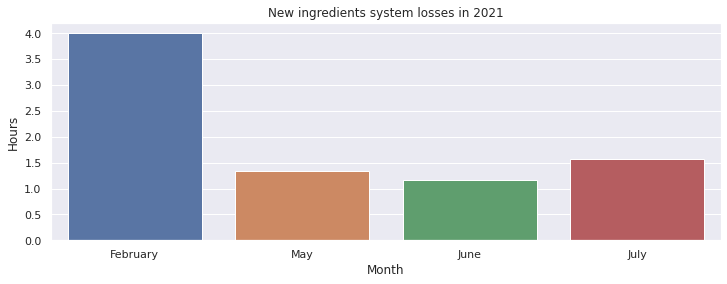

In [ ]:
#Plotting the historic loss
sns.barplot(x='Month', y='Hours', data=group_a[1:])
plt.title('New ingredients system losses in 2021')
plt.show()

In [ ]:
#Exporting to excel into local disk
from google.colab import files
group_a.to_excel('2021_07_31_hist_loss.xlsx', index=False) #==>  Exclude index on created file.
files.download('2021_07_31_hist_loss.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Rework Analysis

## Uploading necessary packages

In [ ]:
#Upgrading plolty
!pip install plotly --upgrade

     |████████████████████████████████| 23.9 MB 13 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
#Customizing data visualization styles
sns.set_theme(rc = {'figure.figsize': (12, 4)})

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded9 = files.upload()

Saving 2021_j4_vrak.xlsx to 2021_j4_vrak.xlsx


In [ ]:
#Storing dataset in a Pandas Dataframe
import io
df9 = pd.read_excel(io.BytesIO(uploaded9['2021_j4_vrak.xlsx']))

In [ ]:
#Checking the dataframe info
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Line            172 non-null    object        
 1   Date            172 non-null    datetime64[ns]
 2   Prod_vol_kg     172 non-null    float64       
 3   Scrap_kg        172 non-null    float64       
 4   Rework_kg       172 non-null    int64         
 5   Gross_waste_kg  172 non-null    float64       
 6   Gross_waste_%   172 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
#Creating cumulative sum of produced volume
df9 = df9.assign(Cum_prod_ton = round((df9['Prod_vol_kg'].cumsum())/1000, 2))
df9.tail()

##Plotting cumulative scrap

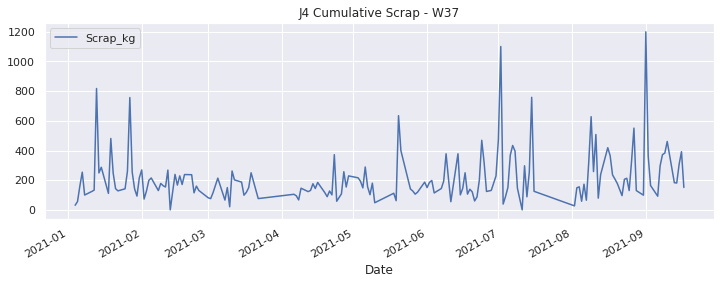

In [ ]:
#Plotting the scrap over time with MatplotLib
df9.plot(x='Date', y='Scrap_kg')
plt.title('J4 Cumulative Scrap - W37')
plt.show()

In [ ]:
#Plotting the scrap over time with Plotly Express
#data_slice = px.data.gapminder().query("city == 'Oslo'")
fig9_a = px.line(data_frame=df9, x='Date', y='Scrap_kg', title='J4 Scrap - W37', width=900, height=450)
fig9_a.show()

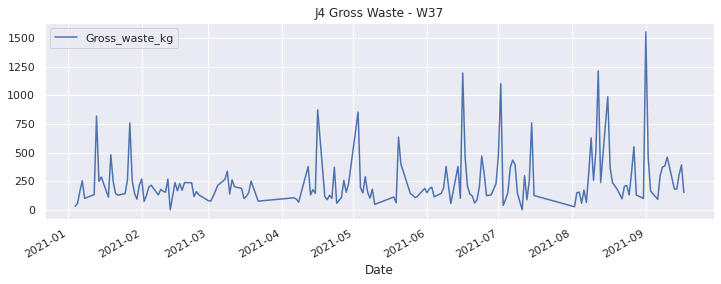

In [ ]:
#Plotting the Gross waste over time
df9.plot(x='Date', y='Gross_waste_kg')
plt.title('J4 Gross Waste - W37')
plt.show()

In [ ]:
#Plotting the Production over time
fig9_b = px.bar(data_frame=df9, x='Date', y='Prod_vol_kg', title='J4 Produced Volumen kg - W37', width=900, height=450)
fig9_b.show()

In [ ]:
#Plotting the Cumulative production in Ton over time
fig9_c = px.line(data_frame=df9, x='Date', y='Cum_prod_ton', title='J4 Cumulative Produced Ton - W37', width=900, height=450)
fig9_c.show()